# p53 Trace Descriptor

In [1]:
import numpy as np 
import pandas as pd
import scipy 
import math 
import copy
from scipy.signal import find_peaks, peak_prominences, peak_widths
from collections import defaultdict
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.nonparametric.smoothers_lowess import lowess 
from sklearn.metrics import auc
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## Figure settings 
plt.rcParams['figure.figsize'] = [10,6]
title_font = {'size':'20', 'color':'black', 'weight':'bold', 'verticalalignment':'bottom'} 
plt.rcParams.update({'font.size': 22, 'font.family': 'Helvetica'})


In [2]:
## Autocorrelation functions
def autocorrelation(trace, r):
    output = np.zeros(r);
    valid_elements = trace > -1;
    mean_value = np.mean(trace[valid_elements]);
    var_value = np.var(trace[valid_elements]);
    for taui in np.arange(0, r):
        tau = np.arange(r)[taui];
        max_index = trace.shape[0] - tau - 2;
        trace_present = trace[0:(max_index + 1)];
        trace_future = trace[(trace.shape[0] - max_index - 1):(trace.shape[0])];
        valid_elements = np.where((trace_present > -1) & (trace_future > -1));
        trace_present = trace_present[valid_elements];
        trace_future = trace_future[valid_elements];
        output[taui] = np.sum((trace_present - mean_value) * (trace_future - mean_value))/(trace_present.shape[0] - 1) / var_value;
    return output
        
def autocorrelationMatrix(matrix, tau, death_time):
    acmatric = np.zeros([matrix.shape[0], tau]);
    for i in np.arange(matrix.shape[0]): 
        Trace = matrix[i,:];
        if death_time[i] > 0: 
            Trace = Trace[0:death_time[i]]
        acmatric[i,:] =  autocorrelation(Trace, tau);
    return acmatric

def rank_osc(matrix, window, tau, death_time):
    if np.any(death_time) == 0: 
        max_time = matrix.shape[1]
    else: 
        max_time = np.max(death_time)
        
    num = matrix.shape[0]
    peak_amp_mat = np.full([num ,max_time-window], np.nan); 
    for j in np.arange(max_time - window):
        ac = autocorrelationMatrix(matrix[:,j:j+window + 1], tau, death_time);
        ac_inverted = -1*ac
        #Peaks
        loc = {}
        pks = {}
        for ii in np.arange(num):
            loc[ii] = find_peaks(ac[ii,:])[0]
            pks[ii] = ac[ii,loc[ii]]
        
        maximum_peaks = [max((len(value)) for value in loc.values())][0]
        peak_loc = np.zeros([num, maximum_peaks]); 
        peak_amp = np.zeros([num, maximum_peaks]);
        for i, (x,y) in enumerate(loc.items()):
            l = len(y)
            for z in np.arange(l): 
                if loc[i][z] > 5: 
                    peak_loc[i,z] = loc[i][z]
                    peak_amp[i,z] = pks[i][z]
        
        #Troughs 
        loc_trough = {}
        trough = {}
        for ii in np.arange(num):
            loc_trough[ii] = find_peaks(ac_inverted[ii,:])[0]
            trough[ii] = ac_inverted[ii,loc_trough[ii]]
        
        minimum_peaks = [max((len(value)) for value in loc_trough.values())][0]
        peak_inv_loc = np.zeros([num, minimum_peaks]); 
        peak_inv_amp = np.zeros([num, minimum_peaks]);
        for i, (x,y) in enumerate(loc_trough.items()):
            l = len(y)
            for z in np.arange(l):
                peak_inv_loc[i,z] = loc_trough[i][z]
                peak_inv_amp[i,z] = trough[i][z]
                                
        for vi in np.arange(num): 
            if sum(peak_loc[vi,:] > 0) == 1 and sum(peak_inv_loc[vi,:] > 0) >= 1 and peak_amp[vi,0] > 0: 
                peak_amp_mat[vi, j] = peak_amp[vi, 0] + np.max(peak_inv_amp[vi, 0])
                
    osc_sum = np.ones(num)*np.nan
    peak_amp_mat[np.isinf(peak_amp_mat)] = np.nan;
    for xi in np.arange(num): 
        if death_time[xi] == 0:
            osc_sum[xi] = np.nansum(peak_amp_mat[xi,0:max_time-window]) 
        if death_time[xi] > 0: 
            osc_sum[xi] = np.nansum(peak_amp_mat[xi,0:death_time[xi]-window]) 

    osc_score_abs = np.ones(num)*np.nan
    for ni in np.arange(num): 
        if death_time[ni] == max_time or death_time[ni] == 0: 
            osc_score_abs[ni] = osc_sum[ni]/(max_time-window);
        else:
            osc_score_abs[ni] = osc_sum[ni]/(death_time[ni]-window*(death_time[ni]/max_time));

            
    osc_score_scaled = (osc_score_abs - osc_score_abs.min()) / (osc_score_abs.max() - osc_score_abs.min())
    
    return osc_score_abs

# User Input
<i>Remember to index from 0! </i>

<b>Data window</b>
- <i>window: </i> Do you want to use the entire trace (<i>False</i>) or calculate for a window of time (<i>True</i>)?
    - If True, set <i>window_start</i> and <i>window_end</i>

<b>Peak detection</b>
- <i>peak_width_req: </i> Width required to count as a "peak"  
- <i>max_peak_height_req: </i> Height required to count as a "peak" 
    - <i>Height = max_peak_height_req*(maximum peak height of trace)</i>

In [3]:
## Data window
window = False
if window == True: 
    window_start, window_end = 0, 140
else:
    window_start, window_end = 0, 0

## Peak detection 
peak_width_req = 4
max_peak_height_req = 0.05

## Data Format
- <i>d:</i> Dynamic data, NxM csv file with N cells at M timepoints, missing values must be -1 or NaN
- <i>death_mat:</i> NxM csv file with N cells at M timepoints, 0's for all values unless time of death (1) <br> **OR** <br> <i>death:</i> Nx1 csv file with N cells, 0's for all values unless dead cell (time of death)

Text(0, 0.5, 'p53 A.U.')

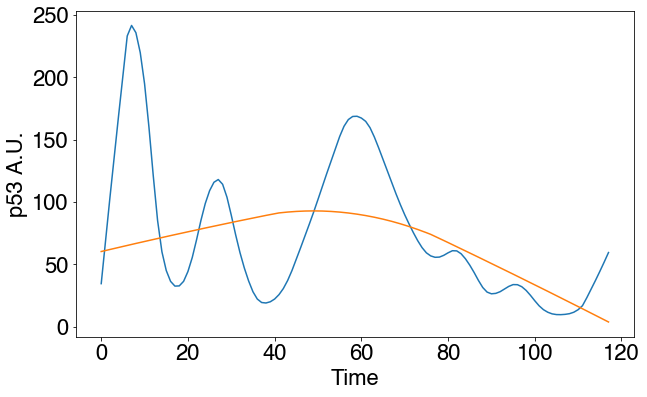

In [5]:
## PREPARE PAULA DATA 
d = np.genfromtxt('data/paula_data.txt', delimiter = ',')
death_mat = np.genfromtxt('data/paula_death_mat.txt', delimiter = ',') #times of death 
death = np.argmax(death_mat, axis = 1)
death_ind = np.where(death > 0)[0] #rows with death 
NUM_OF_TRAJECTORIES = np.shape(d)[0]
MAX_LEN_OF_TRAJECTORY = np.shape(d)[1]

for i in np.arange(NUM_OF_TRAJECTORIES): 
    if death[i] > 0: 
        d[i,death[i]:] = np.nan

if window == True: 
    win_size = np.sum(np.isfinite(d[0, window_start:window_end+1]))
    d_window = np.full([NUM_OF_TRAJECTORIES, win_size], np.nan)
    for i in np.arange(0,NUM_OF_TRAJECTORIES):
        time_in_window = np.sum(np.isfinite(d[i, window_start:death[i]]))
        if death[i] == 0 or (death[i] > 0 and death[i] > window_end):
            d_window[i,:] = d[i,window_start:window_end+1]
        elif death[i] > 0 and window_start < death[i] < window_end: 
            d_window[i,0:time_in_window] = d[i,window_start:int(death[i])] 
        else: 
            continue
    d = d_window
    MAX_LEN_OF_TRAJECTORY = np.shape(d)[1]

# #remove dead cells 
# mask = np.ones(d.shape[0], bool)
# mask[death_ind] = False
# mask
# d = d[mask,:]

if len(death[np.nonzero(death)]) > 0 & (min(death[np.nonzero(death)]) > window_end) == True:
    MIN_LEN_OF_TRAJECTORY = win_size
if len(death[np.nonzero(death)]) > 0 & (min(death[np.nonzero(death)]) < window_end) == True: 
    MIN_LEN_OF_TRAJECTORY = int(np.min(death[np.nonzero(death)]))
else: 
    MIN_LEN_OF_TRAJECTORY = MAX_LEN_OF_TRAJECTORY
MAX_LEN_OF_TRAJECTORY = np.shape(d)[1]

# STL decomposition
trends = np.empty((MAX_LEN_OF_TRAJECTORY,d.shape[0]))
trends[:] = np.nan
seasons = np.empty((MAX_LEN_OF_TRAJECTORY,d.shape[0]))
seasons[:] = np.nan
residuals = np.empty((MAX_LEN_OF_TRAJECTORY,d.shape[0]))
residuals[:] = np.nan

for cell in np.arange(0,d.shape[0]):     
    end = [MAX_LEN_OF_TRAJECTORY, death[cell], window_end]
    masked_end = np.ma.masked_equal(end, 0.0, copy=False)
    ep = masked_end.min()
    dd = np.array(d[cell, :ep])
    stl = STL(dd,period = 7, seasonal = 21) 
    res = stl.fit()
    trends[:ep,cell] = stl.fit().trend
    seasons[:ep,cell] = stl.fit().seasonal
    residuals[:ep,cell] = stl.fit().resid

d = np.transpose(trends)

# STL decomposition
trends_shape = np.empty((MAX_LEN_OF_TRAJECTORY,d.shape[0]))
trends_shape[:] = np.nan
seasons_shape = np.empty((MAX_LEN_OF_TRAJECTORY,d.shape[0]))
seasons_shape[:] = np.nan
residuals_shape = np.empty((MAX_LEN_OF_TRAJECTORY,d.shape[0]))
residuals_shape[:] = np.nan


# peak 5.5 hr in humans 
for cell in np.arange(0,d.shape[0]):     
    end = [MAX_LEN_OF_TRAJECTORY, death[cell], window_end]
    masked_end = np.ma.masked_equal(end, 0.0, copy=False)
    ep = masked_end.min()
    dd = np.array(d[cell, :ep])
    stl = STL(dd,period = 51, seasonal = 21) 
    res = stl.fit()
    trends_shape[:ep,cell] = stl.fit().trend
    seasons_shape[:ep,cell] = stl.fit().seasonal
    residuals_shape[:ep,cell] = stl.fit().resid

d_shape = np.transpose(trends_shape)
d_shape[d_shape < 0] = 0.001

## Plot example smoothed trace with "shape" superimposed
plt.plot(d[1,:])
plt.plot(d_shape[1,:])
plt.xlabel('Time')
plt.ylabel('p53 A.U.')

# Calculate total parameter dictionary 

To add your own parameter, follow template: <i>param['Name'].append(value)</i>

Let me know if you'd like to add your parameter to the lab master copy or submit a pull request! 

In [6]:
param = defaultdict(list)
no_peaks = []
for x in np.arange(NUM_OF_TRAJECTORIES): 
    param['Max'].append(np.nanmax(d[x,:]))
    param['Mean'].append(np.nanmean(d[x,:]))
    param['Median'].append(np.nanmedian(d[x,:]))
    param['Std'].append(np.nanstd(d[x,:]))
    param['Var'].append(np.nanvar(d[x,:]))
    end = [MAX_LEN_OF_TRAJECTORY, death[x], window_end]
    masked_end = np.ma.masked_equal(end, 0.0, copy=False)
    param['Shape 0/end'].append(d[x,0]/d_shape[x,masked_end.min()-1])
    param['Max Gradient'].append(np.nanmax(np.gradient(d[x,:(masked_end.min()-1)])))
    param['Max Shape Gradient'].append(np.nanmax(np.gradient(d_shape[x,:(masked_end.min()-1)])))

    
    peaks, properties = find_peaks(d[x,:], width = peak_width_req, height = param['Max'][x]*max_peak_height_req)
    no_peaks.append(len(properties['peak_heights']))
    # print(len(properties['peak_heights']))
    
    if peaks.shape[0] == 0: # skip if 0 peaks 
        continue 
    param['First Peak'].append(peaks[0])
    param['Peak Prom'].append(np.max(peak_prominences(d[x,:], peaks)[0]))
    param['First Width'].append(properties['widths'][0] )
    param['First Height'].append(properties['peak_heights'][0])
    first_peak_ind = [int(properties['left_ips'][0]), int(properties['right_ips'][0])]
    param['First Peak auc'].append(auc(np.arange(first_peak_ind[0], first_peak_ind[1]), d[x,first_peak_ind[0]:first_peak_ind[1]]))
    #param['First Peak fwhm'].append(peak_widths(d[x,:], peaks, rel_height=0.5)[0][0])
    
    if peaks.shape[0] == 1: # skip if one peak 
        continue 
    param['Second Peak'].append(peaks[1])
    param['Second Width'].append(properties['widths'][1] )
    param['Second Height'].append(properties['peak_heights'][1] )
    second_peak_ind =  [int(properties['left_ips'][1]), int(properties['right_ips'][1])]
    param['Second Peak Auc'].append(auc(np.arange(second_peak_ind[0], second_peak_ind[1]), d[x,second_peak_ind[0]:second_peak_ind[1]]))
    #param['Second Peak Fwhm'].append(peak_widths(d[x,:], peaks, rel_height=0.5)[0][1])  
    
param['Autocorrelation'] = rank_osc(d,100, 90, death).tolist()
param['Number of Peaks'] = no_peaks



/var/folders/4v/s_3yvtk52p9bkz65z37c1zl40000gn/T/ipykernel_5989/1079415484.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  output[taui] = np.sum((trace_present - mean_value) * (trace_future - mean_value))/(trace_present.shape[0] - 1) / var_value;
/var/folders/4v/s_3yvtk52p9bkz65z37c1zl40000gn/T/ipykernel_5989/1079415484.py:15: RuntimeWarning: invalid value encountered in double_scalars
  output[taui] = np.sum((trace_present - mean_value) * (trace_future - mean_value))/(trace_present.shape[0] - 1) / var_value;
/Users/emilyackerman/opt/miniconda3/envs/env_3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilyackerman/opt/miniconda3/envs/env_3.8/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/emilyackerman/opt/miniconda3/envs/env_3.8/lib/python3.8/s

# Plot pairwise pearson correlation between parameters
To plot specific parameters, fill feature_list, <i> for example, feature_list = ['Max', 'Mean', 'First Peak'] </i>

Else, leave  <i> feature_list = [] </i>

<b>List of available features: </b>
- Max: Maximum of trace 
- Mean: Minimum of trace
- Median: Median of trace 
- Std: Standard deviation of trace
- Var: Variance of trace
- Shape 0/end: ratio of p53 at t(0) to p53 at t(final) for trace shape 
- Max Gradient: Maximum value of trace gradient over all time 
- Max Shape Gradient: Maximum value of trace shape gradient over all time 


- First Peak: Time of first peak
- First Width: Width of first peak
- First Height: Height of first peak
- First Peak AUC: Area under curve of first peak 
- First Peak Fwhm: Full width at half max of first peak 


- Second Peak: Time of second peak
- Second Width: Width of second peak
- Second Height: Height of second peak
- Second Peak AUC: Area under curve of second peak 
- Second Peak Fwhm: Full width at half max of second peak 


- Peak Prom: Maximum occurring value of vertical distance between a peak and its lowest contour line
- Number of Peaks: Number of peaks within trace


- Autocorrelation: Oscillation score of the total trace

In [7]:
# Specific feature list
feature_list = [] #'Max', 'Mean', 'First Peak', 'Autocorrelation', 'Number of Peaks']
## To retreive full param matrix after plotting specific feature list, uncomment below
# param = copy.deepcopy(param_full)

if len(feature_list) > 0: 
    param_full = copy.deepcopy(param)
    subset = defaultdict(list)
    for key, i in param.items(): 
        if key in feature_list: 
            subset[key].extend(np.array(param[key]))# for key, i in param.items() if key in list
    param = subset

df = pd.DataFrame.from_dict(param, orient='index').T
df_dead = df.loc[death_ind,:]
df_alive = df.loc[np.where(death == 0)[0], :]

In [8]:
## Plot for all cells 
corr = df.corr()
with pd.option_context('display.precision', 2):
    corr = corr.style.background_gradient(cmap='coolwarm',axis=None)
corr

,Max,Mean,Median,Std,Var,Shape 0/end,Max Gradient,Max Shape Gradient,First Peak,Peak Prom,First Width,First Height,First Peak auc,Second Peak,Second Width,Second Height,Second Peak Auc,Autocorrelation,Number of Peaks
Max,1.00,0.91,0.73,0.95,0.80,0.12,0.81,0.91,0.26,0.90,0.23,0.61,0.52,0.16,0.07,0.35,0.33,0.29,0.14
Mean,0.91,1.00,0.90,0.92,0.77,0.17,0.69,0.78,0.30,0.83,0.21,0.65,0.54,0.16,0.12,0.41,0.41,0.34,0.07
Median,0.73,0.90,1.00,0.67,0.47,0.18,0.60,0.53,0.18,0.68,0.18,0.63,0.51,0.21,0.16,0.46,0.49,0.41,0.12
Std,0.95,0.92,0.67,1.00,0.90,0.16,0.70,0.90,0.28,0.87,0.20,0.55,0.46,0.09,0.05,0.27,0.25,0.24,0.05
Var,0.80,0.77,0.47,0.90,1.00,0.12,0.42,0.82,0.24,0.77,0.09,0.32,0.25,0.06,0.03,0.25,0.21,0.12,-0.06
Shape 0/end,0.12,0.17,0.18,0.16,0.12,1.00,0.02,-0.02,-0.03,0.08,-0.09,0.20,0.05,0.04,0.06,0.00,0.02,0.04,-0.19
Max Gradient,0.81,0.69,0.60,0.70,0.42,0.02,1.00,0.67,0.15,0.71,0.23,0.59,0.50,0.13,0.07,0.25,0.24,0.23,0.29
Max Shape Gradient,0.91,0.78,0.53,0.90,0.82,-0.02,0.67,1.00,0.23,0.84,0.13,0.36,0.30,0.07,0.00,0.22,0.19,0.30,0.19
First Peak,0.26,0.30,0.18,0.28,0.24,-0.03,0.15,0.23,1.00,0.09,0.11,0.41,0.34,0.09,0.06,0.21,0.22,0.04,-0.13
Peak Prom,0.90,0.83,0.68,0.87,0.77,0.08,0.71,0.84,0.09,1.00,0.18,0.47,0.40,0.16,0.11,0.40,0.38,0.36,0.16


In [9]:
## Plot for dead cells only
corr_dead = df_dead.corr()
with pd.option_context('display.precision', 2):
    corr_dead = corr_dead.style.background_gradient(cmap='coolwarm',axis=None)
corr_dead

,Max,Mean,Median,Std,Var,Shape 0/end,Max Gradient,Max Shape Gradient,First Peak,Peak Prom,First Width,First Height,First Peak auc,Second Peak,Second Width,Second Height,Second Peak Auc,Autocorrelation,Number of Peaks
Max,1.00,0.90,0.75,0.96,0.87,0.14,0.85,0.84,0.42,0.87,0.19,0.84,0.68,0.28,0.17,0.51,0.54,0.26,0.12
Mean,0.90,1.00,0.93,0.90,0.83,0.22,0.66,0.67,0.43,0.80,0.19,0.85,0.70,0.27,0.20,0.55,0.59,0.36,-0.04
Median,0.75,0.93,1.00,0.70,0.61,0.24,0.52,0.45,0.23,0.75,0.16,0.73,0.60,0.29,0.20,0.56,0.61,0.38,-0.02
Std,0.96,0.90,0.70,1.00,0.91,0.21,0.80,0.81,0.51,0.78,0.20,0.86,0.70,0.21,0.15,0.42,0.45,0.26,-0.01
Var,0.87,0.83,0.61,0.91,1.00,0.10,0.62,0.83,0.64,0.65,0.06,0.76,0.57,0.24,0.18,0.50,0.55,0.29,-0.05
Shape 0/end,0.14,0.22,0.24,0.21,0.10,1.00,0.06,-0.14,-0.03,0.06,-0.09,0.24,0.09,0.05,0.08,-0.02,0.02,0.11,-0.15
Max Gradient,0.85,0.66,0.52,0.80,0.62,0.06,1.00,0.72,0.21,0.83,0.16,0.66,0.52,0.18,0.09,0.34,0.34,0.10,0.21
Max Shape Gradient,0.84,0.67,0.45,0.81,0.83,-0.14,0.72,1.00,0.50,0.67,0.09,0.56,0.45,0.20,0.08,0.36,0.40,0.19,0.23
First Peak,0.42,0.43,0.23,0.51,0.64,-0.03,0.21,0.50,1.00,0.15,0.06,0.44,0.35,0.09,0.07,0.22,0.22,0.09,-0.18
Peak Prom,0.87,0.80,0.75,0.78,0.65,0.06,0.83,0.67,0.15,1.00,0.16,0.67,0.54,0.33,0.23,0.60,0.64,0.33,0.16


In [10]:
## Plot for living cells only
corr_alive = df_alive.corr()
with pd.option_context('display.precision', 2):
    corr_alive = corr_alive.style.background_gradient(cmap='coolwarm', axis=None)
corr_alive

,Max,Mean,Median,Std,Var,Shape 0/end,Max Gradient,Max Shape Gradient,First Peak,Peak Prom,First Width,First Height,First Peak auc,Second Peak,Second Width,Second Height,Second Peak Auc,Autocorrelation,Number of Peaks
Max,1.00,0.91,0.70,0.95,0.82,0.64,0.73,0.95,0.12,0.91,0.18,0.37,0.32,-0.03,-0.05,0.31,0.13,0.27,-0.67
Mean,0.91,1.00,0.87,0.95,0.83,0.51,0.65,0.86,0.08,0.85,0.13,0.35,0.27,-0.05,0.01,0.30,0.17,0.31,-0.60
Median,0.70,0.87,1.00,0.67,0.47,0.17,0.65,0.61,0.10,0.62,0.11,0.38,0.27,-0.02,0.10,0.30,0.23,0.46,-0.37
Std,0.95,0.95,0.67,1.00,0.93,0.69,0.60,0.93,0.06,0.90,0.14,0.28,0.23,-0.06,-0.05,0.27,0.10,0.18,-0.68
Var,0.82,0.83,0.47,0.93,1.00,0.79,0.34,0.84,-0.02,0.84,0.06,0.11,0.08,-0.07,-0.06,0.25,0.07,0.05,-0.67
Shape 0/end,0.64,0.51,0.17,0.69,0.79,1.00,0.14,0.74,-0.08,0.75,-0.06,-0.01,-0.04,-0.07,-0.06,0.33,0.06,-0.04,-0.51
Max Gradient,0.73,0.65,0.65,0.60,0.34,0.14,1.00,0.59,0.14,0.55,0.20,0.53,0.43,0.04,0.04,0.24,0.21,0.28,-0.30
Max Shape Gradient,0.95,0.86,0.61,0.93,0.84,0.74,0.59,1.00,-0.00,0.90,0.06,0.21,0.15,-0.09,-0.08,0.28,0.09,0.30,-0.70
First Peak,0.12,0.08,0.10,0.06,-0.02,-0.08,0.14,-0.00,1.00,0.06,0.81,0.49,0.75,0.21,0.07,0.03,0.06,-0.06,-0.07
Peak Prom,0.91,0.85,0.62,0.90,0.84,0.75,0.55,0.90,0.06,1.00,0.10,0.28,0.22,-0.06,-0.00,0.37,0.18,0.34,-0.65


In [11]:
# Plot difference between live and dead cell correlations 
corr_diff = df_alive.corr() - df_dead.corr()
with pd.option_context('display.precision', 2):
    corr_diff = corr_diff.style.background_gradient(cmap='coolwarm', axis=None)
corr_diff

,Max,Mean,Median,Std,Var,Shape 0/end,Max Gradient,Max Shape Gradient,First Peak,Peak Prom,First Width,First Height,First Peak auc,Second Peak,Second Width,Second Height,Second Peak Auc,Autocorrelation,Number of Peaks
Max,0.00,0.00,-0.05,-0.02,-0.05,0.50,-0.13,0.11,-0.30,0.04,-0.01,-0.46,-0.36,-0.31,-0.22,-0.20,-0.41,0.00,-0.79
Mean,0.00,0.00,-0.06,0.04,-0.00,0.29,-0.01,0.19,-0.34,0.05,-0.06,-0.50,-0.44,-0.32,-0.19,-0.25,-0.43,-0.05,-0.56
Median,-0.05,-0.06,0.00,-0.02,-0.14,-0.07,0.13,0.16,-0.13,-0.13,-0.06,-0.35,-0.34,-0.31,-0.10,-0.26,-0.38,0.09,-0.35
Std,-0.02,0.04,-0.02,0.00,0.02,0.48,-0.20,0.12,-0.44,0.12,-0.06,-0.58,-0.47,-0.27,-0.20,-0.15,-0.35,-0.08,-0.67
Var,-0.05,-0.00,-0.14,0.02,0.00,0.69,-0.28,0.01,-0.65,0.19,-0.00,-0.65,-0.49,-0.31,-0.24,-0.25,-0.48,-0.24,-0.62
Shape 0/end,0.50,0.29,-0.07,0.48,0.69,0.00,0.08,0.88,-0.05,0.68,0.03,-0.25,-0.13,-0.12,-0.14,0.34,0.05,-0.15,-0.36
Max Gradient,-0.13,-0.01,0.13,-0.20,-0.28,0.08,0.00,-0.13,-0.07,-0.27,0.04,-0.13,-0.09,-0.15,-0.04,-0.09,-0.13,0.18,-0.50
Max Shape Gradient,0.11,0.19,0.16,0.12,0.01,0.88,-0.13,0.00,-0.50,0.24,-0.03,-0.35,-0.29,-0.29,-0.16,-0.08,-0.31,0.11,-0.93
First Peak,-0.30,-0.34,-0.13,-0.44,-0.65,-0.05,-0.07,-0.50,0.00,-0.09,0.75,0.05,0.40,0.12,0.00,-0.19,-0.17,-0.15,0.11
Peak Prom,0.04,0.05,-0.13,0.12,0.19,0.68,-0.27,0.24,-0.09,0.00,-0.06,-0.39,-0.32,-0.39,-0.23,-0.23,-0.47,0.00,-0.81


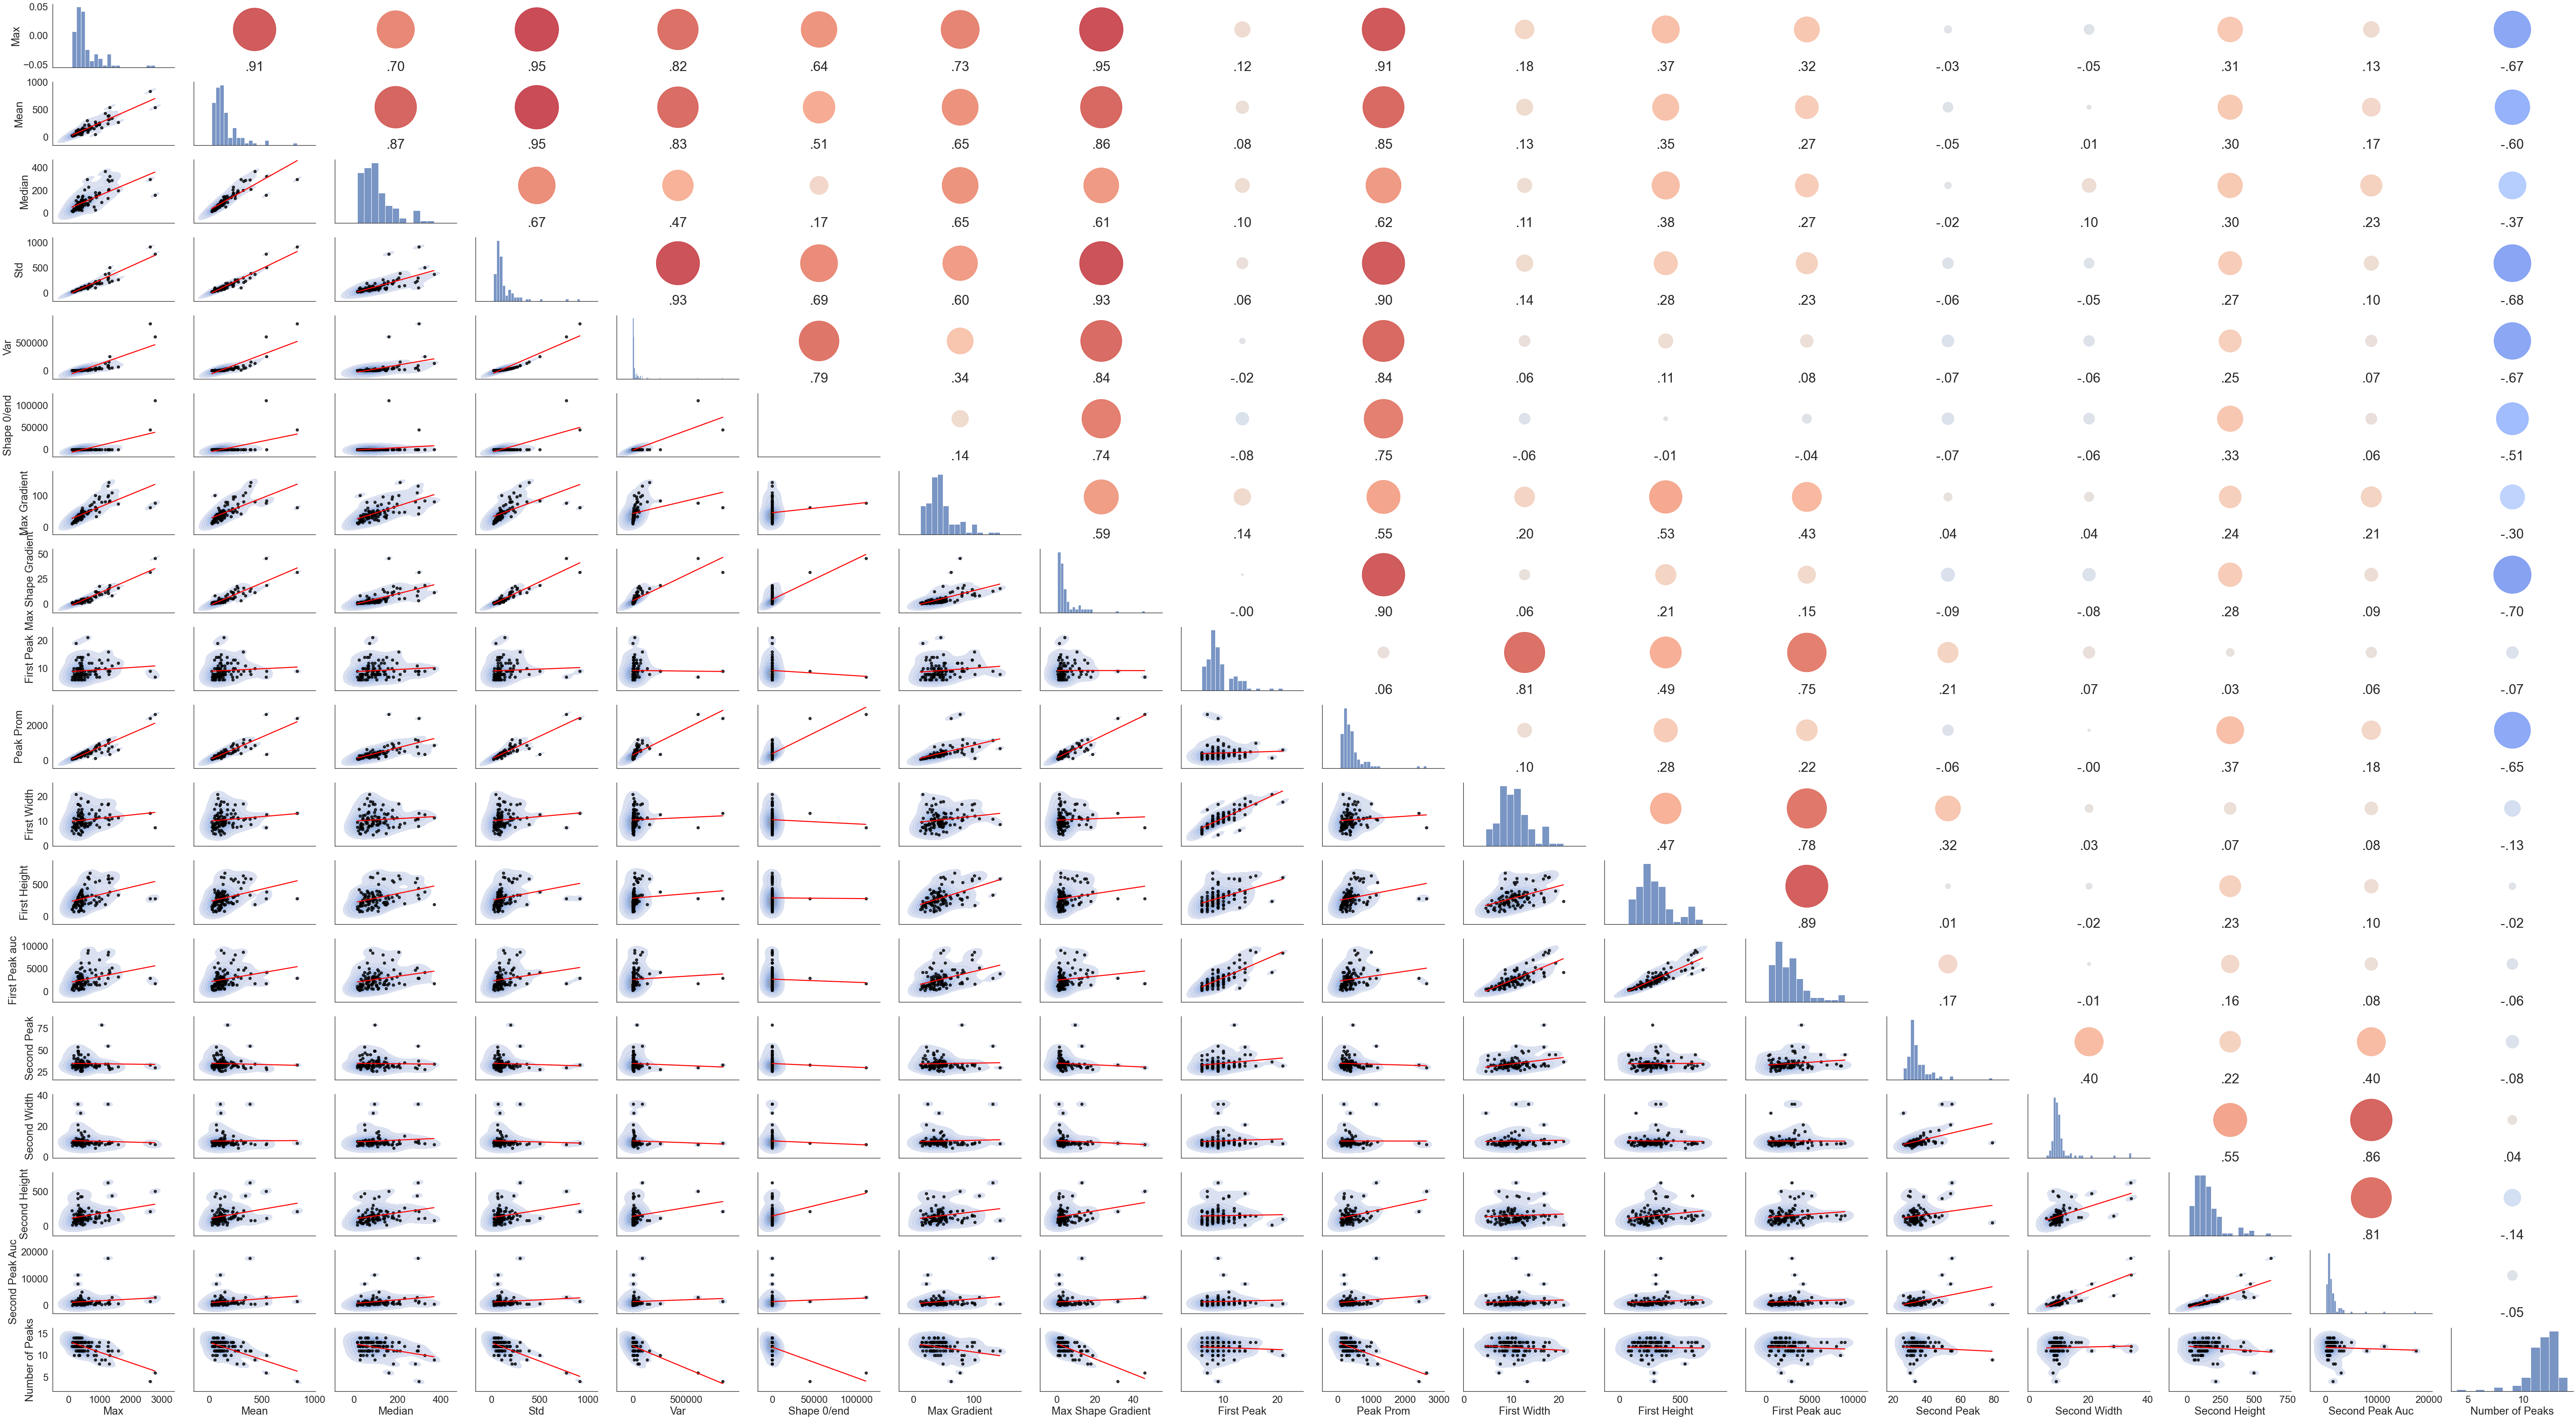

In [125]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    p_stars = ''
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.6], marker_size, [corr_r], alpha=0.8, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = 30#abs(corr_r) * 30 + 10
    ax.annotate(corr_text+p_stars, [.5, 0,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=2)
g = sns.PairGrid(df_alive, aspect=1.8, diag_sharey=False)
g.map_lower(sns.kdeplot, fill = True, alpha = 0.5)#, cmap='Blues_d')
g.map_lower(sns.regplot, ci=False, line_kws={'color': 'red'}, color = 'black') #, loess = True
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

# Plot fast fourier transform 

[Text(0.5, 1.0, 'Freq')]

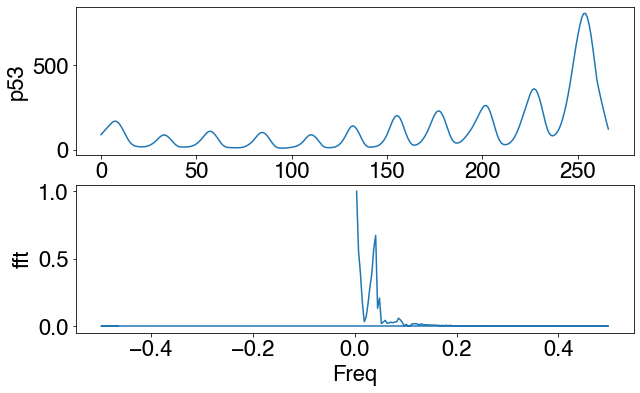

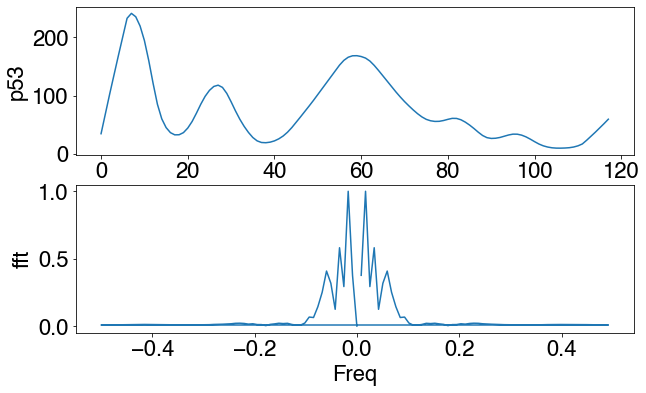

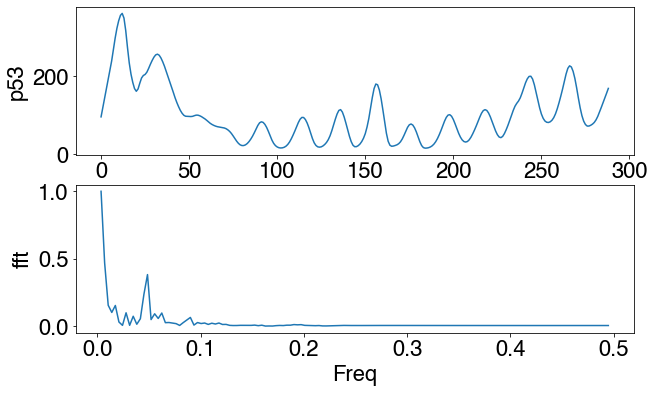

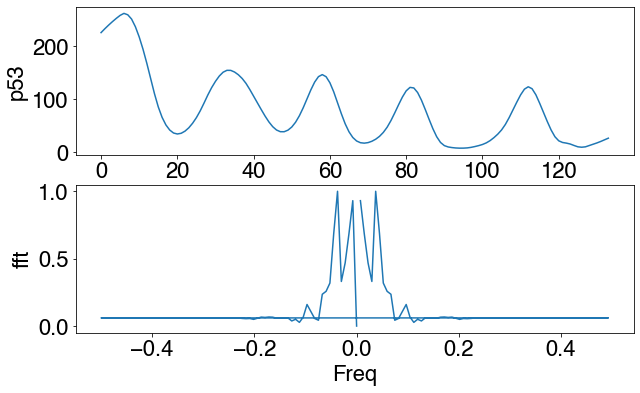

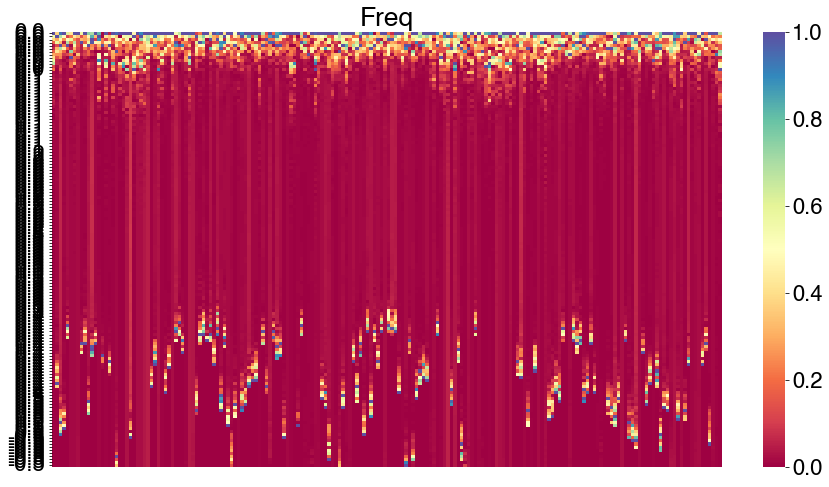

In [12]:
fft_spectrum = np.zeros([NUM_OF_TRAJECTORIES, MAX_LEN_OF_TRAJECTORY])
freq = np.zeros([NUM_OF_TRAJECTORIES, MAX_LEN_OF_TRAJECTORY])
for i in np.arange(NUM_OF_TRAJECTORIES):
    d_temp = d[i,np.isnan(d[i,:]) == False]
#     print(d_temp.shape)
#     print(np.abs(np.fft.fft(d_temp).real))
    fft_spectrum[i,:d_temp.shape[0]] = np.abs(np.fft.fft(d_temp).real)
#     print(i, d_temp, fft_spectrum)
    freq[i,:d_temp.shape[0]] = np.fft.fftfreq(np.arange(d_temp.shape[0]).shape[0])

# Normalize to max value for trace 
fft_spectrum = fft_spectrum/np.max(fft_spectrum[:,1:], axis = 1)[:,None]

# Example trace with fft 
fig, ax = plt.subplots()
ax1 = plt.subplot(2,1,1) 
ax1.plot(np.arange(MAX_LEN_OF_TRAJECTORY), d[0,:])
ax1.set_ylabel('p53') 
ax1.set_xlabel('Time (h)') 
ax2 = plt.subplot(2,1,2) 
ax2.plot(freq[0,1:round(MAX_LEN_OF_TRAJECTORY/2)], fft_spectrum[0,1:round(MAX_LEN_OF_TRAJECTORY/2)])
ax2.set_ylabel('fft') 
ax2.set_xlabel('Freq') 

fig, ax = plt.subplots()
ax1 = plt.subplot(2,1,1) 
ax1.plot(np.arange(MAX_LEN_OF_TRAJECTORY), d[1,:])
ax1.set_ylabel('p53') 
ax1.set_xlabel('Time (h)') 
ax2 = plt.subplot(2,1,2) 
ax2.plot(freq[1,1:round(MAX_LEN_OF_TRAJECTORY/2)], fft_spectrum[1,1:round(MAX_LEN_OF_TRAJECTORY/2)])
ax2.set_ylabel('fft') 
ax2.set_xlabel('Freq') 

fig, ax = plt.subplots()
ax1 = plt.subplot(2,1,1) 
ax1.plot(np.arange(MAX_LEN_OF_TRAJECTORY), d[2,:])
ax1.set_ylabel('p53') 
ax1.set_xlabel('Time (h)') 
ax2 = plt.subplot(2,1,2) 
ax2.plot(freq[2,1:round(MAX_LEN_OF_TRAJECTORY/2)], fft_spectrum[2,1:round(MAX_LEN_OF_TRAJECTORY/2)])
ax2.set_ylabel('fft') 
ax2.set_xlabel('Freq') 

fig, ax = plt.subplots()
ax1 = plt.subplot(2,1,1) 
ax1.plot(np.arange(MAX_LEN_OF_TRAJECTORY), d[3,:])
ax1.set_ylabel('p53') 
ax1.set_xlabel('Time (h)') 
ax2 = plt.subplot(2,1,2) 
ax2.plot(freq[3,1:round(MAX_LEN_OF_TRAJECTORY/2)], fft_spectrum[3,1:round(MAX_LEN_OF_TRAJECTORY/2)])
ax2.set_ylabel('fft') 
ax2.set_xlabel('Freq') 
# Fft for all traces 
plt.figure(figsize = (15,8))
sns.heatmap(fft_spectrum[death_ind,1:round(MAX_LEN_OF_TRAJECTORY/2)].T,  cmap="Spectral", xticklabels = [], yticklabels = freq[0,1:round(MAX_LEN_OF_TRAJECTORY/2)].round(1)).set(title = 'Freq')


# Plot parameter distributions
To plot specific parameters, fill plot_list, <i> for example, plot_list = ['Max', 'Mean', 'Number of Peaks', 'Autocorrelation'] </i>

Reported mean and std are for all cells


Max mean:  403.70258477447277      std dev:  367.39079403384716
Mean mean:  111.04728895977371      std dev:  108.75707094055136
Number of Peaks mean:  8.366438356164384      std dev:  3.3493973573105564
Autocorrelation mean:  0.010715202609832873      std dev:  0.04304723849542942


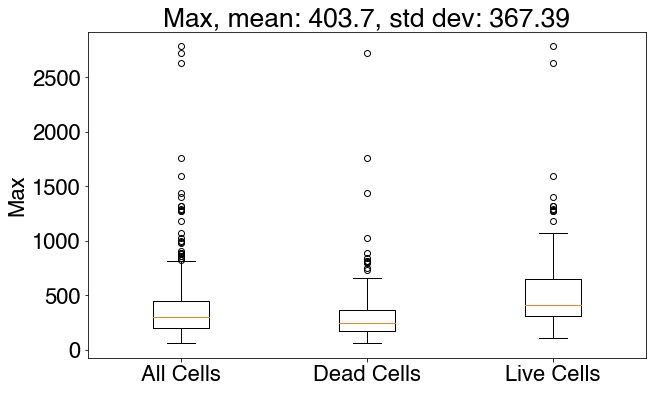

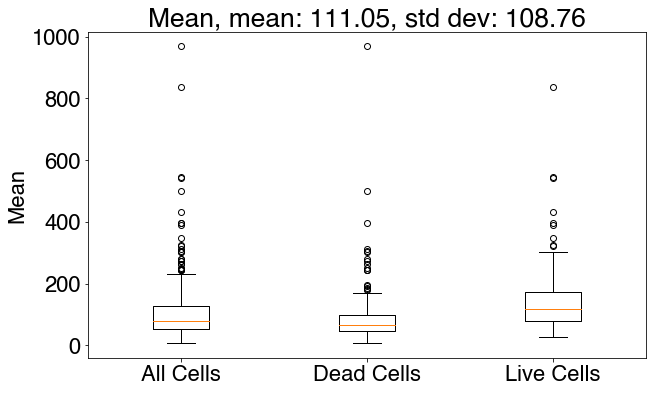

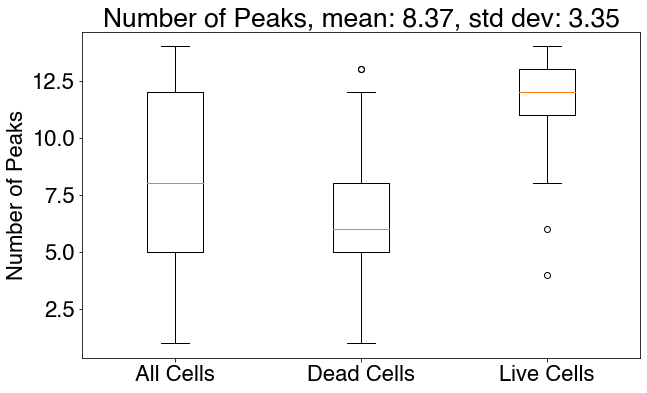

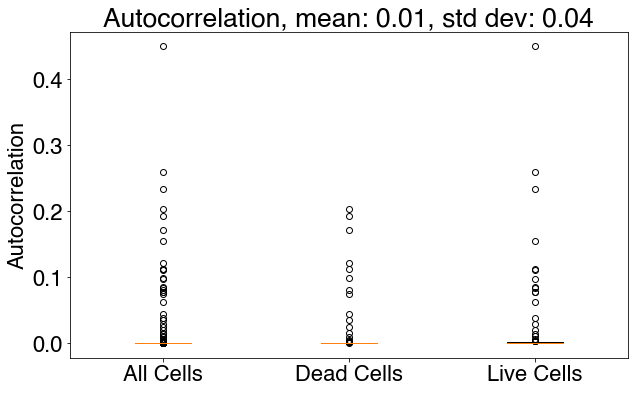

In [13]:
# Plot list
plot_list = ['Max', 'Mean', 'Number of Peaks', 'Autocorrelation']

for p in np.arange(len(plot_list)): 
    print(plot_list[p],'mean: ', np.mean(param[plot_list[p]]), '     std dev: ', np.std(param[plot_list[p]]))
    plt.figure()
    plt.boxplot([df[plot_list[p]],df_dead[plot_list[p]],df_alive[plot_list[p]]]);
    plt.xticks([1,2,3], ['All Cells', 'Dead Cells', 'Live Cells'])
    plt.ylabel(plot_list[p])
    title = plot_list[p] + ', mean: ' + str(np.mean(param[plot_list[p]]).round(2)) + ', std dev: '+ str(np.std(param[plot_list[p]]).round(2))
    plt.title(title)

# Plot cumulative p53

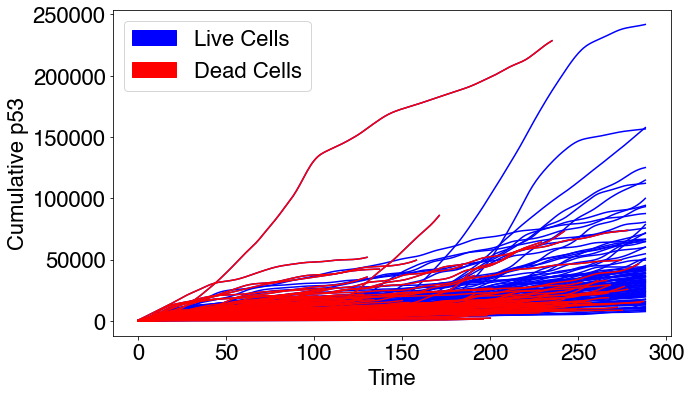

In [14]:
fig = plt.figure()
[plt.plot(np.cumsum(d[x,:]), color='blue') for x in np.arange(NUM_OF_TRAJECTORIES)];
[plt.plot(np.cumsum(d[x,:]), color='red') for x in death_ind];
plt.xlabel('Time')
plt.ylabel('Cumulative p53')
# plt.legend(['Live Cells', 'Dead Cells'])
blue_patch = mpatches.Patch(color='blue', label='Live Cells')
red_patch = mpatches.Patch(color='red', label='Dead Cells')
plt.legend(handles=[blue_patch, red_patch])

# Plot gradient

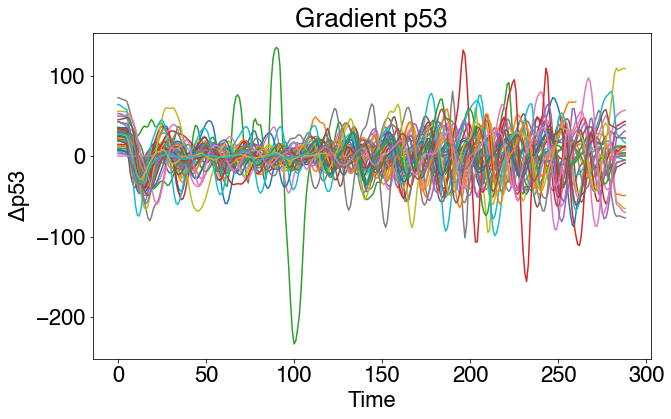

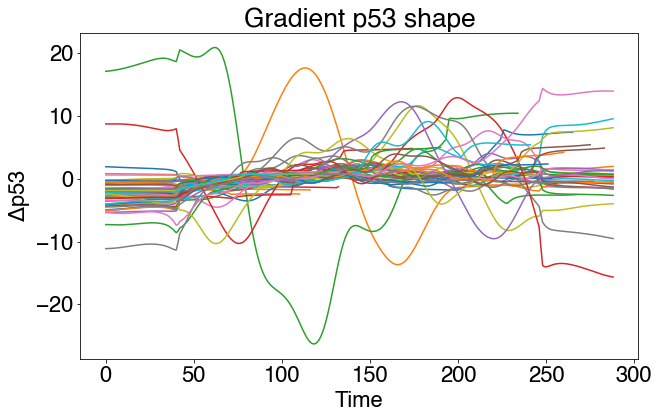

In [15]:
## Plot Gradient 
plt.figure()
[plt.plot(np.gradient(d[x,:])) for x in np.arange(60)];
plt.xlabel('Time')
plt.ylabel('$\Delta$p53')
plt.title('Gradient p53')
# Plot gradient of trace shape 
plt.figure()
[plt.plot(np.gradient(d_shape[x,:])) for x in np.arange(60)];
plt.xlabel('Time')
plt.ylabel('$\Delta$p53')
plt.title('Gradient p53 shape');